# Deep Q-Learning

* Deep Q-Learning harness the power of deep learning with so-called Deep Q-Networks. These are standard feed forward neural networks which are utilized for calculating Q-Value. In this case, the agent has to store previous experiences in a local memory and use max output of neural networks to get new Q-Value.
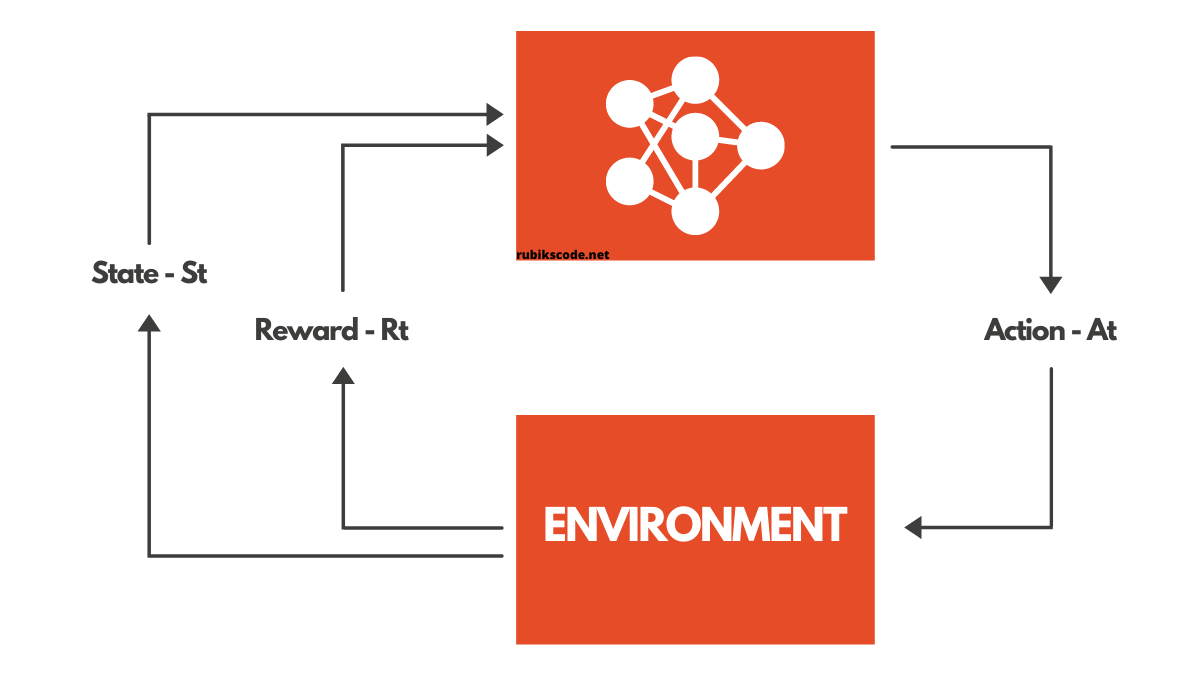

* The important thing to notice here is that Deep Q-Networks don’t use standard supervised learning, simply because we don’t have labeled expected output. We depend on the policy or value functions in reinforcement learning, so the target is continuously changing with each iteration.

* Because of this reason the agent doesn’t use just one neural network, but two of them. So, how does this all fit together? The first network, called Q-Network is calculating Q-Value in the state St, while the other network, called Target Network is calculating Q-Value in the state St+1.
* Speaking more formally, given the current state St, the Q-Network retrieves the action-values Q(St,a). At the same time the Target-Network uses the next state St+1 to calculate Q(St+1, a) for the Temporal Difference target.

* In order to stabilize this training of two networks, on each N-th iteration parameters of the Q-Network are copied over to the Target Network. The whole process is presented in the image below.
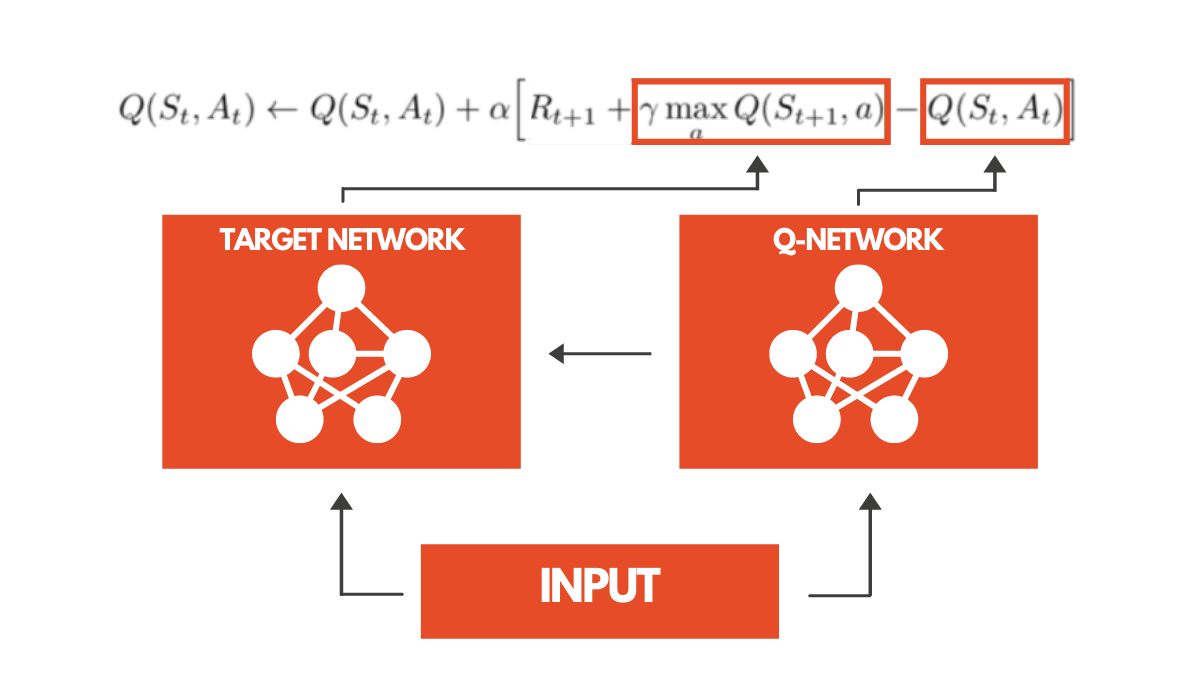


we can split the whole process of Deep Q-Learning into steps:

1. Provide the state of the environment to the agent. The agent uses Target Network and Q-Network to get the Q-Values of all possible actions in the defined state.
2. Pick the action a, based on the epsilon value. Meaning, either select a random action (exploration) or select the action with the maximum Q-Value (exploitation).
3. Perform action a
4. Observe reward r and the next state s’
5. Store these information in the experience replay memory <s, s’, a, r>
6. Sample random batches from experience replay memory and perform training of the Q-Network.
7. Each Nth iteration, copy the weights values from the Q-Network to the Target Network.
8. Repeat steps 2-7 for each episode

## Deep Q-Learning Implementation 

In [10]:
import numpy as np
import random
from IPython.display import clear_output
from collections import deque
import progressbar

import gym

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam

In [11]:
# !pip3 install progressbar

we imported deque from collections. We will use it for experience replay memory. After this we can create the environment:

In [12]:
enviroment = gym.make("Taxi-v3").env
enviroment.render()

print('Number of states: {}'.format(enviroment.observation_space.n))
print('Number of actions: {}'.format(enviroment.action_space.n))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Number of states: 500
Number of actions: 6


* We use the make function to instantiate an object of the Taxi-v3 environment.
* The current state of the environment and the agent can be presented with the render method.
* We can access all states of the environment using observation_space property and all actions of the environment using action_space.
* This environment has 500 states and 6 possible actions.
* reset method which resets the environment and returns a random initial state.
* Another one is the step method which steps the environment by one time-step and performs an action

In [13]:
class Agent:
    def __init__(self, enviroment, optimizer):
        
        # Initialize atributes
        self._state_size = enviroment.observation_space.n
        self._action_size = enviroment.action_space.n
        self._optimizer = optimizer
        
        self.expirience_replay = deque(maxlen=2000)
        
        # Initialize discount and exploration rate
        self.gamma = 0.6
        self.epsilon = 0.1
        
        # Build networks
        self.q_network = self._build_compile_model()
        self.target_network = self._build_compile_model()
        self.alighn_target_model()

    def store(self, state, action, reward, next_state, terminated):
        self.expirience_replay.append((state, action, reward, next_state, terminated))
    
    def _build_compile_model(self):
        model = Sequential()
        model.add(Embedding(self._state_size, 10, input_length=1))
        model.add(Reshape((10,)))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(self._action_size, activation='linear'))
        
        model.compile(loss='mse', optimizer=self._optimizer)
        return model

    def alighn_target_model(self):
        self.target_network.set_weights(self.q_network.get_weights())
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return enviroment.action_space.sample()
        
        q_values = self.q_network.predict(state)
        return np.argmax(q_values[0])

    def retrain(self, batch_size):
        minibatch = random.sample(self.expirience_replay, batch_size)
        
        for state, action, reward, next_state, terminated in minibatch:
            
            target = self.q_network.predict(state)
            
            if terminated:
                target[0][action] = reward
            else:
                t = self.target_network.predict(next_state)
                target[0][action] = reward + self.gamma * np.amax(t)
            
            self.q_network.fit(state, target, epochs=1, verbose=0)

 ### initialized the Agent inside of the constructor

In [14]:
def __init__(self, enviroment, optimizer):
    # Initialize atributes
    self._state_size = enviroment.observation_space.n
    self._action_size = enviroment.action_space.n
    self._optimizer = optimizer

    self.expirience_replay = deque(maxlen=2000)

    # Initialize discount and exploration rate
    self.gamma = 0.6
    self.epsilon = 0.1

    # Build networks
    self.q_network = self._build_compile_model()
    self.target_network = self._build_compile_model()
    self.alighn_target_model()

* First we initialize size of the state and action space based on the environment object that is passed to this agent.
* We also initialize an optimizer and the experience reply memory.
* Then we build the Q-Network and the Target Network with the _build_compile_model method and align their weights with the alighn_target_model method.
* The _build_compile_model method is probably the most interesting one in this whole implementation, because it contains the core of the implementation.

In [15]:
def _build_compile_model(self):
    model = Sequential()
    model.add(Embedding(self._state_size, 10, input_length=1))
    model.add(Reshape((10,)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(self._action_size, activation='linear'))

    model.compile(loss='mse', optimizer=self._optimizer)
    return model

* We see that the first layer that is used in this model is Embedding layer.
* The problem that we are facing with the Taxi-v3 environment is that it returns discrete value (single number) for the state. This means that we need to reduce number of potential values a little bit.
* The Embedding layer, the parameter input_dimensions refers to the number of values we have
* output_dimensions refers to the vector space we want to reduce them.
* we want to represent 500 possible states by 10 values and Embedding layer is used for exactly this


Based on the epsilon value we either invoke Q-Network to make a prediction, or we pick a random action. 

In [16]:
def act(self, state):
    if np.random.rand() <= self.epsilon:
        return enviroment.action_space.sample()

    q_values = self.q_network.predict(state)
    return np.argmax(q_values[0])

In retrain method we pick random samples from the experience replay memory and train the Q-Network:

In [17]:
def retrain(self, batch_size):
    minibatch = random.sample(self.expirience_replay, batch_size)

    for state, action, reward, next_state, terminated in minibatch:

        target = self.q_network.predict(state)

        if terminated:
            target[0][action] = reward
        else:
            t = self.target_network.predict(next_state)
            target[0][action] = reward + self.gamma * np.amax(t)

        self.q_network.fit(state, target, epochs=1, verbose=0)

create an object of Agent class and prepare for training

In [18]:
optimizer = Adam(learning_rate=0.01)
agent = Agent(enviroment, optimizer)

batch_size = 32
# num_of_episodes = 100
num_of_episodes = 2
timesteps_per_episode = 1000
agent.q_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 10)             5000      
                                                                 
 reshape (Reshape)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 50)                550       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 6)                 306       
                                                                 
Total params: 8,406
Trainable params: 8,406
Non-trainable params: 0
_________________________________________________________________


### training of DQN

In [ ]:
for e in range(0, num_of_episodes):
    # Reset the enviroment
    state = enviroment.reset()
    state = np.reshape(state, [1, 1])
    
    # Initialize variables
    reward = 0
    terminated = False
    
    bar = progressbar.ProgressBar(maxval=timesteps_per_episode/10, widgets=\
[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for timestep in range(timesteps_per_episode):
        # Run Action
        action = agent.act(state)
        
        # Take action    
        next_state, reward, terminated, info = enviroment.step(action) 
        next_state = np.reshape(next_state, [1, 1])
        agent.store(state, action, reward, next_state, terminated)
        
        state = next_state
        
        if terminated:
            agent.alighn_target_model()
            break
            
        if len(agent.expirience_replay) > batch_size:
            agent.retrain(batch_size)
        
        if timestep%10 == 0:
            bar.update(timestep/10 + 1)
    
    bar.finish()
    if (e + 1) % 10 == 0:
        print("**********************************")
        print("Episode: {}".format(e + 1))
        enviroment.render()
        print("**********************************")
